In [94]:

import numpy as np
import matplotlib.pyplot as plt

In [ ]:

class Node:
    def __init__(self):
        self.voltage = 0
        self.connectedComponents = []
        

class Component:
    def __init__(self, value):
        if (value.real != 0):
            Exception("component values are real")
        self.name = "None"
        self.value = value
        self.nodeForward = Node()
        self.nodeForward.connectedComponents.append(self)
        self.nodeBackward = Node()
        self.nodeBackward.connectedComponents.append(self)
        self.current = 0  
        self.impedance = 0
        
        


class Resistor(Component):
    def __init__(self, resistance):
        super().__init__(resistance)
        
    def setFrequency(self, omega):
        self.impedance = self.value

class Capacitor(Component):
    def __init__(self, capacitance):
        super().__init__(capacitance)
    def setFrequency(self, omega):
        self.impedance = 1 / (1j * omega * self.value)
class VoltageSource(Component):
    def __init__(self, value):
        super().__init__(value)
    def setFrequency(self, omega):
        self.impedance = None

class GroundNode(Node):
    def __init__(self):
        super().__init__()

class DependentVoltageSource(VoltageSource):
    def __init__(self, value, node1, node2):
        super().__init__(value)
    
class OperationalAmplifier(Component):
    def __init__(self, value, R_in, R_out): # gain value
        super().__init__(value)
        self.name = "Op Amp"
        R_in = Resistor(R_in)
        R_out = Resistor(R_out)
        ground = GroundNode()
        
        self.nodeForward = R_out.nodeBackward
        self.node_Vplus = R_in.nodeBackward
        self.node_Vminus = R_in.nodeForward
        
    

class Circuit:
    def __init__(self):
        self.components = []
        self.nodes = set()
    
    def addComponent(self, component):
        self.components.append(component)
        self.nodes.add(component.nodeForward)
        self.nodes.add(component.nodeBackward)
    def connectComponents(self, comp1, comp2):
        # Create merged node and get old nodes
        merged_node = Node()
        removed_node1 = comp1.nodeBackward
        removed_node2 = comp2.nodeForward
        
        # Merge connected components
        merged_node.connectedComponents = (
            removed_node1.connectedComponents +
            removed_node2.connectedComponents
        )
        
        # Update all components' node references
        for component in merged_node.connectedComponents:
            # Update forward references
            if component.nodeForward in {removed_node1, removed_node2}:
                component.nodeForward = merged_node
            # Update backward references
            if component.nodeBackward in {removed_node1, removed_node2}:
                component.nodeBackward = merged_node
        
        # Update circuit nodes
        self.nodes -= {removed_node1, removed_node2}
        self.nodes.add(merged_node)

    def setCircuitFrequency(self, omega):
        self.angularFrequency = omega
        for component in self.components:
            component.setFrequency(omega)

        
    def solveSystem(self):
        impedances = [comp.impedance for comp in self.components]
        
        # Get reference node (ground)
        largest_vsrc = self._get_largest_vsource()
        if largest_vsrc:
            ref_node = largest_vsrc.nodeBackward
        else:  # Fallback if no voltage sources
            ref_node = next(iter(self.nodes)) if self.nodes else None
            if not ref_node:
                raise ValueError("No nodes in circuit")
        
        non_ref_nodes = [n for n in self.nodes if n != ref_node]
        num_nodes = len(non_ref_nodes)
        
        # Count voltage sources
        v_sources = [c for c in self.components if isinstance(c, VoltageSource)]
        num_v_sources = len(v_sources)
        
        # create matrix
        size = num_nodes + num_v_sources
        A = np.zeros((size, size), dtype=complex)
        b = np.zeros(size, dtype=complex)
        
        # Create node index mapping
        node_indices = {node: idx for idx, node in enumerate(non_ref_nodes)}
        
        # Process regular nodes (KCL equations)
        for node_idx, node in enumerate(non_ref_nodes):
            for comp in node.connectedComponents:
                # Determine connected node
                other_node = comp.nodeForward if comp.nodeBackward == node else comp.nodeBackward
                
                # Handle component contribution
                if isinstance(comp, (Resistor, Capacitor)):
                    admittance = 1/comp.impedance if comp.impedance != 0 else 0
                    
                    A[node_idx, node_idx] += admittance
                    
                    # Mutual admittance if not reference
                    if other_node in node_indices:
                        A[node_idx, node_indices[other_node]] -= admittance
                        
                elif isinstance(comp, VoltageSource):
                    pass
        
        # Add voltage source equations
        for vsrc_idx, vsrc in enumerate(v_sources):
            row = num_nodes + vsrc_idx
            
            n_plus = vsrc.nodeForward
            n_minus = vsrc.nodeBackward
        
            if n_plus in node_indices:
                A[row, node_indices[n_plus]] = 1
            if n_minus in node_indices:
                A[row, node_indices[n_minus]] = -1
            b[row] = vsrc.value
 
            current_var_col = num_nodes + vsrc_idx

            if n_plus in node_indices:
                A[node_indices[n_plus], current_var_col] += 1
            if n_minus in node_indices:
                A[node_indices[n_minus], current_var_col] -= 1

        x = np.linalg.solve(A, b)
        
        # Update variables
        for node, idx in node_indices.items():
            node.voltage = x[idx]
        
        for vsrc_idx, vsrc in enumerate(v_sources):
            vsrc.current = x[num_nodes + vsrc_idx]        
        
        for comp in self.components:
            if isinstance(comp, (Resistor, Capacitor)):
                try:
                    V_plus = comp.nodeForward.voltage
                    V_minus = comp.nodeBackward.voltage
                    
                    # Handle floating components (both nodes non-reference)
                    if comp.nodeForward != ref_node and comp.nodeBackward != ref_node:
                        comp.current = (V_plus - V_minus) / comp.impedance
                    else:
                        comp.current = (V_plus - V_minus) / comp.impedance
                        
                except ZeroDivisionError:
                    comp.current = float('inf')  # Handle short circuits
                    print(f"Warning: Zero impedance in {comp.componentName}")
            
            
            
    def _get_largest_vsource(self):
        max_voltage = -float('inf')
        largest_vsrc = None
        for comp in self.components:
            if isinstance(comp, VoltageSource) and comp.value > max_voltage:
                max_voltage = comp.value
                largest_vsrc = comp
        return largest_vsrc



In [96]:
def generateLowPassFilter(resistance, capacitance, voltage):
    
    R = Resistor(resistance)  
    C = Capacitor(capacitance)  
    Vs = VoltageSource(voltage)  
   
    circuit = Circuit()
    circuit.addComponent(Vs)
    circuit.addComponent(R)
    circuit.addComponent(C)
    
    circuit.connectComponents(Vs, R)
    circuit.connectComponents(R, C)
    circuit.connectComponents(C, Vs)  
    
    frequencies = np.logspace(0, 5, 200)  # 1Hz to 100kHz
    magnitudes = []
    phases = []
    
    for f in frequencies:
        omega = 2 * np.pi * f
        
        circuit.setCircuitFrequency(omega)
        
        circuit.solveSystem()
        
        V_in = Vs.nodeForward.voltage - Vs.nodeBackward.voltage
        V_out = C.nodeForward.voltage - C.nodeBackward.voltage

        H = V_out / V_in if abs(V_in) > 1e-9 else 0
        magnitudes.append(20 * np.log10(np.abs(H)))
        phases.append(np.angle(H, deg=True))

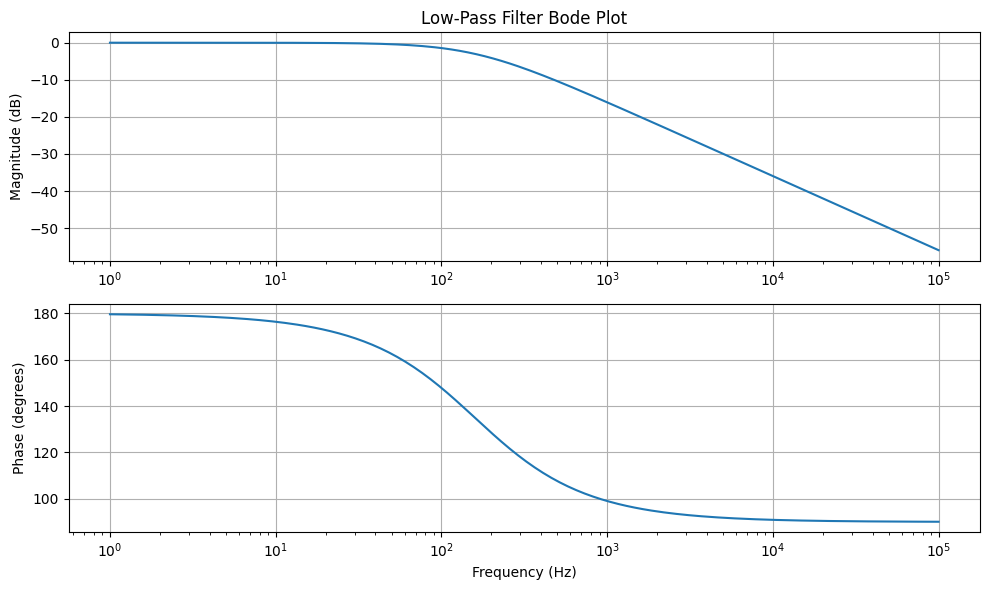

In [97]:
def generateLowPassFilterGraph(resistance, capacitance, voltage):
    
    R = Resistor(resistance)  
    C = Capacitor(capacitance)  
    Vs = VoltageSource(voltage)  
   
    circuit = Circuit()
    circuit.addComponent(Vs)
    circuit.addComponent(R)
    circuit.addComponent(C)
    
    circuit.connectComponents(Vs, R)
    circuit.connectComponents(R, C)
    circuit.connectComponents(C, Vs)  
    
    frequencies = np.logspace(0, 5, 200)  # 1Hz to 100kHz
    magnitudes = []
    phases = []
    
    for f in frequencies:
        omega = 2 * np.pi * f
        
        circuit.setCircuitFrequency(omega)
        
        circuit.solveSystem()
        
        V_in = Vs.nodeForward.voltage - Vs.nodeBackward.voltage
        V_out = C.nodeForward.voltage - C.nodeBackward.voltage

        H = V_out / V_in if abs(V_in) > 1e-9 else 0
        magnitudes.append(20 * np.log10(np.abs(H)))
        phases.append(np.angle(H, deg=True))

    # Plotting
    plt.figure(figsize=(10, 6))
    
    # Magnitude plot
    plt.subplot(2, 1, 1)
    plt.semilogx(frequencies, magnitudes)
    plt.title('Low-Pass Filter Bode Plot')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    
    # Phase plot
    plt.subplot(2, 1, 2)
    plt.semilogx(frequencies, phases)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run the plot generator
generateLowPassFilterGraph(resistance=1000, capacitance=1e-6, voltage=5)
